In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import re as re
import warnings
#import wordcloud
warnings.simplefilter("ignore", DeprecationWarning)
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [3]:
#from google.colab import files
#uploaded = files.upload()

Saving data_final.xlsx to data_final.xlsx


In [115]:
df=pd.read_excel("data_final.xlsx")
df=df.dropna()
df[:2]
len(df)

2969

**1. Obvious fact - Colloquial words used as fillers in chorus and repitions feature on the word cloud, and they are mostly bigrams, which also feature in Adhi's list of most frequent bigrams**

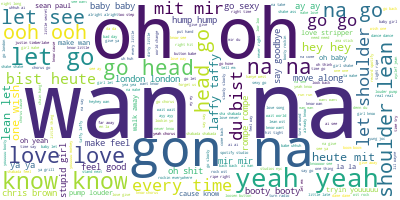

In [556]:
# #Brute force word cloud on all lyrics
# from wordcloud import WordCloud
# long_string = ','.join(df['lyrics_lem'])
# wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
# wordcloud.generate(long_string)
# wordcloud.to_image()

In [548]:
#!pip install vaderSentiment

In [116]:
#Just a copy of sentiment analysis code
#sentiment analyser
analyser = SentimentIntensityAnalyzer()

#getting the sentiment scores
chk=[]
for items in df['lyrics_lem']:
    chk.append(analyser.polarity_scores(items))

#into a dataframe
scorels=pd.DataFrame(chk)
df=df.merge(scorels,left_index=True, right_index=True)
df[:2]

,artist,lyrics,name,rank,song,url,urltag,year,lyrics_clean,lyrics_lem,engagement_high,song_id,neg,neu,pos,compound
0,Chicago,[Verse 1]\nWhen you called me up this morning\...,Hot100,1,Look Away,https://www.billboard.com/charts/year-end/1989...,hot-100-songs,1989,called morning told new love found said happy ...,call morning tell new love find say happy real...,1,4fb25ccd98e9aff41259ccc11c3c636609180e8e,0.022,0.677,0.302,0.9937
1,Bobby Brown,Get busy!\n\n[Chorus]\nEverybody's talking all...,Hot100,2,My Prerogative,https://www.billboard.com/charts/year-end/1989...,hot-100-songs,1989,get busy chorus everybody talking stuff let li...,get busy chorus everybody talk stuff let live ...,1,db815992930d3614142c44154b78798028c7207e,0.090,0.847,0.063,-0.6494


**2. High, Medium, Low buckets based on ranks**

In [117]:
#Topics from the entire list don't give many insights, so trying to group the songs into buckets based on ranks
df['rank_dec'] = pd.qcut(df['rank'], 3, labels=False)
df_high=df[df['rank_dec']==0]
df_med=df[df['rank_dec']==1]
df_low=df[df['rank_dec']==2]

In [118]:
#Function getting most common words - to be used later
def most_common_words(string_series):
    prune_list=['like','chorus','know','say','oh','na','hey','wanna','ya','yeah','go','uh','let','see','bist','du','mir','mit','heute','rompe','shabada','record','spotify'\
              ,'studios','la','ha','feel','nyc','real','keep','lookin','wan','ya','make','tell','come','love','baby','girl','cause','time','ai','man','girl','head','way','right','need'\
              ,'te','wt','yo','ta','end','ke','nd','ly','sy','wit','da','em','fi','od','try','ay','boy','nce','mi','ss','sp','things','think',
               'bitch','shit','nigga','niggas','hook','verse','bridge','outro','fuck']
    string_series_prune=[]
    for items in string_series:
        for word in prune_list:
            if word in items:
                items=items.replace(word,'')
        string_series_prune.append(items)
    count_vectorizer = CountVectorizer(stop_words='english')
    count_data = count_vectorizer.fit_transform(string_series_prune)
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = list(zip(words, total_counts))

    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:30]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    print(count_dict)
    plt.figure(2, figsize=(10, 10/1.6180))
    plt.subplot(title='Most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts)
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    #return new_dict
    #long_string=','.join(string_series_prune)
    #wordcloud = WordCloud(background_color="white", max_words=30, contour_width=3, contour_color='steelblue')
    #return wordcloud.generate(long_string).to_image()


**3. Most common words by rank bucket**
- Have removed the common words which occur across groups and also some slang words - subjective, we can play around with this
- Apart from the common top words like 'love','boy,'girl' etc., which feature across buckets, following are the top words across buckets. There seem to be a difference


[('look', 2618.0), ('life', 2404.0), ('leave', 2252.0), ('little', 2193.0), ('night', 2002.0), ('turn', 1911.0), ('pre', 1854.0), ('heart', 1704.0), ('run', 1611.0), ('stop', 1595.0), ('break', 1525.0), ('ne', 1524.0), ('thing', 1519.0), ('hear', 1515.0), ('hit', 1506.0), ('lean', 1488.0), ('rock', 1476.0), ('world', 1470.0), ('walk', 1455.0), ('arou', 1439.0), ('money', 1421.0), ('rd', 1412.0), ('tonight', 1378.0), ('bout', 1362.0), ('ght', 1294.0), ('mean', 1283.0), ('ffy', 1281.0), ('intro', 1276.0), ('eye', 1265.0), ('big', 1260.0)]


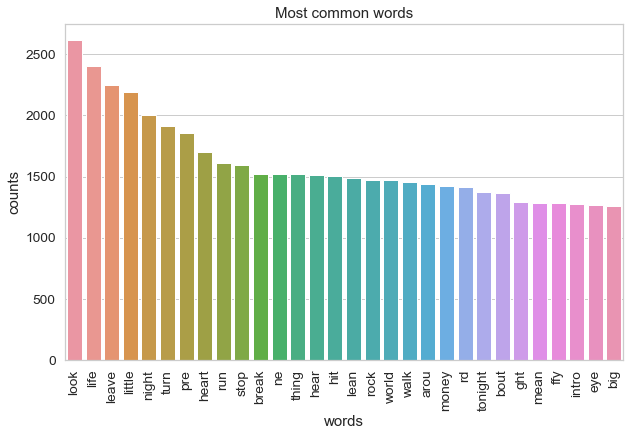

In [119]:
most_common_words(df['lyrics_lem'])

In [6]:
#most_common_words(df_med['lyrics_lem'])

In [7]:
#most_common_words(df_low['lyrics_lem'])

**4. Popular artists by sentiment in each bucket**

In [8]:
# #No difference in the positive vs negative percentages across groups
# print('Percentage of positive/neutral songs by buckets:')
# print('High')
# print(df_high[df_high['compound']>0]['song'].count()/df_high['song'].count())
# print('Med')
# print(df_med[df_med['compound']>0]['song'].count()/df_med['song'].count())
# print('Low')
# print(df_low[df_low['compound']>0]['song'].count()/df_low['song'].count())

# #Artists in high bucket who have highest number of songs under each bucket-sentiment combination
# print('\n')
# print('High Positive:')
# print(df_high[df_high['compound']>0]['artist'].value_counts()[:10])
# print('\n')
# print('High Negative:')
# print(df_high[df_high['compound']<0]['artist'].value_counts()[:10])

# print('\n')
# print('Medium Positive:')
# print(df_med[df_med['compound']>0]['artist'].value_counts()[:10])
# print('\n')
# print('Medium Negative:')
# print(df_med[df_med['compound']<0]['artist'].value_counts()[:10])

# print('\n')
# print('Low Positive:')
# print(df_low[df_low['compound']>0]['artist'].value_counts()[:10])
# print('\n')
# print('Low Negative:')
# print(df_low[df_low['compound']<0]['artist'].value_counts()[:10])



**5. Topic modelling**

**Topics in overall data**

In [120]:
#Removing words from series, I added a few more words to the original list
def top_mod(string_series):
    prune_list=['like','chorus','know','say','oh','na','hey','wanna','ya','yeah','go','uh','let','see','bist','du','mir','mit','heute','rompe','shabada','record','spotify'\
              ,'studios','la','ha','feel','nyc','real','keep','lookin','wan','ya','make','tell','come','love','baby','girl','cause','time','ai','man','girl','head','way','right','need'\
              ,'te','wt','yo','ta','end','ke','nd','ly','sy','wit','da','em','fi','od','try','ay','boy','nce','mi','ss','sp','things','think',
               'bitch','shit','nigga','niggas','hook','verse','bridge','outro','fuck','lil','ffy','lo','feat','el','pre','ng'
               ,'ok']
    string_series_prune=[]
    for items in string_series:
        for word in prune_list:
            if word in items:
                items=items.replace(word,'')
        string_series_prune.append(items)
    ser = pd.Series( (v for v in string_series_prune) )
    return ser

In [121]:
#Function for topic modeling
def print_topics(model, count_vectorizer, num_words):
    words = count_vectorizer.get_feature_names()
    for topic_num, topic_words in enumerate(model.components_):
        print("\nTopic #%d:" % topic_num)
        print(" ".join([words[i]
                        for i in topic_words.argsort()[:-num_words-1:-1]]))

In [132]:
#parameters
number_topics = 4
number_words = 8

#LDA model
lda = LDA(n_components=number_topics, n_jobs=-1, random_state=17)
lda.fit(count_data)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=4, n_jobs=-1,
                          perp_tol=0.1, random_state=17, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [133]:
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(top_mod(df['lyrics_lem']))

print("Topics found via LDA") 
print_topics(lda,count_vectorizer, number_words)

Topics found via LDA

Topic #0:
night wish life sexy sw bad se turn

Topic #1:
lean little leave walk rock heart rd tonight

Topic #2:
booty money hit bout hump meet mean run

Topic #3:
se hear turn home grill nothi als best


RandomSeed 43 Topics : club, love, heartbreak, dance
RS 98 Topics : dance, love, money
RS 63 Topics : Money, Dance, Love
Final seed = 17: club, love, dance, misc

In [134]:
#get words
words=count_vectorizer.get_feature_names()
words_df=pd.DataFrame(words)
#word distribution for each topic
word_dist=pd.DataFrame(lda.components_)
word_dist.T.rename(columns={0:'T0',1:'T1',2:'T2',3:'T3'}).head()
#Look at word vs distribution
words_df.merge(word_dist.T,left_index=True, right_index=True)\
.rename(columns={'0_x':'words','0_y':'T0',1:'T1',2:'T2',3:'T3'}).head()

,words,T0,T1,T2,T3
0,aa,0.264176,0.258395,48.757889,21.719539
1,aaa,0.253293,4.776681,102.718339,0.251687
2,aaaa,0.250003,0.254704,6.242898,0.252395
3,aaaaa,0.250003,1.247239,0.250310,0.252449
4,aaaaaaaaaaaa,0.250007,0.250005,0.250005,10.249983


In [135]:
#getting topic weights
weights=lda.transform(count_data)
topic_weights=pd.DataFrame(weights)
topic_weights.head()
#columns = Topic ; rows = words index

,0,1,2,3
0,0.220157,0.770466,0.004770,0.004607
1,0.371333,0.476666,0.002302,0.149698
2,0.345298,0.299079,0.003237,0.352385
3,0.395930,0.341244,0.259522,0.003304
4,0.043819,0.944593,0.005813,0.005775


In [137]:
df=df.merge(topic_weights, left_index=True, right_index=True)

In [138]:
# df=df.sort_values(by=['engagement_score'])
# q1=np.percentile(df['engagement_score'], 25)
# q3=np.percentile(df['engagement_score'], 75)
#average topic scores for low and high engagement quartile
pd.DataFrame({'Topic':['1','2','3','4'],
              'Low_engagement':df[df['engagement_high']==0]\
              [df.columns[-number_topics:]].mean(),\
              'High_engagement':df[df['engagement_high']==1][df.columns[-number_topics:]].mean()})
#rows = topic name

,Topic,Low_engagement,High_engagement
0,1,0.191819,0.195225
1,2,0.430736,0.394694
2,3,0.162268,0.165326
3,4,0.215178,0.244755


In [149]:
df.head()

,artist,lyrics,name,rank,song,url,urltag,year,lyrics_clean,lyrics_lem,...,song_id,neg,neu,pos,compound,rank_dec,0,1,2,3
0,Chicago,[Verse 1]\nWhen you called me up this morning\...,Hot100,1,Look Away,https://www.billboard.com/charts/year-end/1989...,hot-100-songs,1989,called morning told new love found said happy ...,call morning tell new love find say happy real...,...,4fb25ccd98e9aff41259ccc11c3c636609180e8e,0.022,0.677,0.302,0.9937,0,0.220157,0.770466,0.004770,0.004607
1,Bobby Brown,Get busy!\n\n[Chorus]\nEverybody's talking all...,Hot100,2,My Prerogative,https://www.billboard.com/charts/year-end/1989...,hot-100-songs,1989,get busy chorus everybody talking stuff let li...,get busy chorus everybody talk stuff let live ...,...,db815992930d3614142c44154b78798028c7207e,0.090,0.847,0.063,-0.6494,0,0.371333,0.476666,0.002302,0.149698
2,Poison,[Verse 1]\nWe both lie silently still in the d...,Hot100,3,Every Rose Has Its Thorn,https://www.billboard.com/charts/year-end/1989...,hot-100-songs,1989,lie silently still dead night although lie clo...,lie silently still dead night although lie clo...,...,4f6283ee0b9f9e18763adb1c987b50c5e705dc13,0.163,0.588,0.249,0.9423,0,0.345298,0.299079,0.003237,0.352385
3,Paula Abdul,[Verse 1]\nLost in a dream\nI don't know which...,Hot100,4,Straight Up,https://www.billboard.com/charts/year-end/1989...,hot-100-songs,1989,lost dream know way go ahlet say seem baby mov...,lose dream know way go ahlet say seem baby mov...,...,cace324cef06cc6e71ec16470a97dd20390d3491,0.045,0.488,0.467,0.9991,0,0.395930,0.341244,0.259522,0.003304
4,Janet Jackson,[Verse 1]\nShot like an arrow going through my...,Hot100,5,Miss You Much,https://www.billboard.com/charts/year-end/1989...,hot-100-songs,1989,shot like arrow going heart pain feel feel whe...,shoot like arrow go heart pain feel feel whene...,...,15ae333443d0bb5dde729d4f05989ff860531cde,0.311,0.576,0.113,-0.9739,0,0.043819,0.944593,0.005813,0.005775


**Clustering**

In [192]:
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

In [153]:
X = df.iloc[:,[12,13,14,17,18,19,20]]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

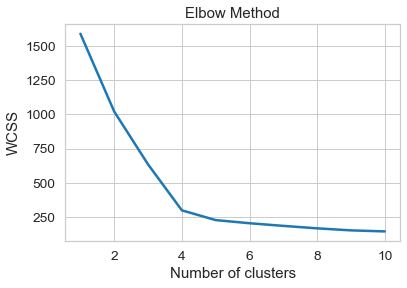

In [154]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=3, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [155]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=3, random_state=0)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=4, n_init=3, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [165]:
# # Plotting the cluster centers and the data points on a 2D plane
# plt.scatter(X[:, 0], X[:, -1])
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x')
# plt.title('Data points and cluster centroids')
# plt.show()

In [162]:
df['cluster'] = pd.Series(kmeans.labels_)

In [168]:
df['cluster'].value_counts()

3.0    1297
1.0     620
0.0     582
2.0     458
Name: cluster, dtype: int64

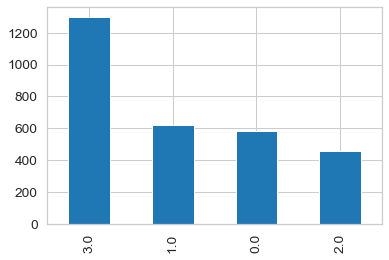

In [180]:
df['cluster'].value_counts().plot(kind='bar')

In [189]:
for i in range(4):    
    print('Cluster:',i)
    print(df[df['cluster']==i]['artist'].value_counts()[:5])

Cluster: 0
Rihanna              36
Ne-Yo                33
Justin Timberlake    19
T.I.                 18
The Fray             17
Name: artist, dtype: int64
Cluster: 1
Nickelback               33
Fall Out Boy             19
Bon Jovi                 17
Danity Kane              17
Red Hot Chili Peppers    17
Name: artist, dtype: int64
Cluster: 2
Justin Timberlake Featuring T.I.    17
Ludacris Featuring Pharrell         17
John Mayer                          17
The Black Eyed Peas                 17
Cassie                              16
Name: artist, dtype: int64
Cluster: 3
Kelly Clarkson              38
Chris Brown                 37
The All-American Rejects    34
Ne-Yo                       21
Nickelback                  19
Name: artist, dtype: int64


In [191]:
for i in range(4):    
    print('Cluster:',i)
    print(df[df['cluster']==i]['engagement_high'].value_counts())

Cluster: 0
0    430
1    152
Name: engagement_high, dtype: int64
Cluster: 1
0    453
1    167
Name: engagement_high, dtype: int64
Cluster: 2
0    344
1    114
Name: engagement_high, dtype: int64
Cluster: 3
0    990
1    307
Name: engagement_high, dtype: int64


**Recommending**

In [196]:
df['ID'] = df['artist'].index

In [250]:
#playing with df because get random missing rows/indices

#len(df) 2961
#df.iloc[2615:2623,]
#df.iloc[pd.np.r_[2049:2052, 2056:2060]]
#for i, r in df.iloc[1:].iterrows():
#for index, value in df.iloc[pd.np.r_[0:2052, 2054:2961]].iterrows():
#    print(value['ID'])

In [237]:
#define X including sentiment and topic %s only
X = df.iloc[0:2052,[12,13,14,17,18,19,20]]
len(X)

2052

In [238]:
#find cosine similarity and most similar items
cosine_similarities = cosine_similarity(X)
results = {}
for index,value in df.iloc[0:2052,].iterrows(): #iterates through all the rows
    similar_indices = cosine_similarities[index].argsort()[:-6:-1]
    similar_items = [(cosine_similarities[index][i], df['ID'][i]) for i in similar_indices]
    results[value['ID']] = similar_items[1:]

In [253]:
def artist(id):
    return df.loc[df['ID'] == id]['artist'].tolist()[0]
def song(id):
    return df.loc[df['ID'] == id]['song'].tolist()[0]
def recommend(id, num):
    if (num == 0):
        print("Unable to recommend any songs as you have not chosen the number of songs to be recommended")    
    else :
        print("Recommending " + str(num) + " similar songs to  " + song(id) + " by " + artist(id))
        
    recs = results[id][:num]
    for rec in recs:
        print("You may also like to listen to: " + song(rec[1]) + " by " + artist(rec[1]) + " (score:" + str(rec[0]) + ")")


In [261]:
#recommend(98,3)
#recommend(2000,3)
#recommend(2050,3)
recommend(1975,3)

Recommending 3 similar songs to  Boom Boom Pow by The Black Eyed Peas
You may also like to listen to: Vogue by Madonna (score:0.9823458783710146)
You may also like to listen to: We Didn't Start The Fire by Billy Joel (score:0.982162157644208)
You may also like to listen to: Live Your Life by T.I. Featuring Rihanna (score:0.9818337161710186)
